In [42]:
import os
import io
import json
import re
import base64

import pymongo as pm

%matplotlib inline
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from matplotlib import pylab, mlab
from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd

from PIL import Image

### Design

For experiment details, see README: https://github.com/hawkrobe/reference_games/blob/master/experiments/3dObjects/sketchpad_repeated/README.md

Each pair now only sees objects from one of the categories (birds, chairs, cars, dogs), each containing 8 objects.

There are three phases to this experiment: pre: All 8 objects sketched repeating: A subset of 4 objects sketched 6 times each, mini-blocked. post: All 8 objects sketched again

For a total of 8 + 24 + 8 = 40 trials total.

We want to counterbalance the category assignment across pairs.

Target pilot sample size: 4 * 5 = 20 pairs (matching sketchpad_basic size).

## Import csv

In [14]:
D = pd.read_csv('../../../data/3dObjects/sketchpad_repeated/feedback_pilot1_group_data.csv')
D

,Unnamed: 0,gameID,trialNum,condition,target,repetition,drawDuration,outcome,response,numStrokes,svgStringLength,svgStringLengthPerStroke,svgStringStd,trialType,png
0,0,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,1,repeated,robin,0,16.015,True,robin,4,885,221.250000,244.189860,0_repeated,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,1,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,2,repeated,nightingale,0,4.372,True,nightingale,3,644,214.666667,253.396045,0_repeated,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,2,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,3,repeated,crow,0,4.317,True,crow,3,782,260.666667,266.651250,0_repeated,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,3,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,4,control,tomtit,0,16.011,True,tomtit,7,987,141.000000,135.702405,0_control,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,4,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,5,repeated,cuckoo,0,3.324,True,cuckoo,3,1216,405.333333,490.181146,0_repeated,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,5,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,6,control,bluejay,0,11.494,True,bluejay,5,411,82.200000,57.415677,0_control,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,6,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,7,control,sparrow,0,22.941,True,sparrow,4,1052,263.000000,220.312278,0_control,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,7,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,8,control,pigeon,0,9.574,True,pigeon,6,943,157.166667,137.441402,0_control,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,8,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,9,repeated,robin,1,8.115,True,robin,6,810,135.000000,130.070494,1_repeated,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,9,4372-c277d1be-60c6-46b4-854b-753ba73a8e32,10,repeated,cuckoo,1,5.766,True,cuckoo,4,1264,316.000000,403.834743,1_repeated,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


### get summary statistics

In [15]:
all_games = np.unique(D['gameID'])
repeated_strokes = []
control_strokes = []
repeated_svgLength = []
control_svgLength = []
repeated_svgStd = []
control_svgStd = []
repeated_svgLengthPS = []
control_svgLengthPS = []
repeated_drawDuration = []
control_drawDuration = []
repeated_accuracy = []
control_accuracy = []
for game in all_games:    
    repeated_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'repeated')]['numStrokes'].mean())
    control_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'control')]['numStrokes'].mean())
    repeated_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'repeated')]['svgStringLength'].mean())
    control_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'control')]['svgStringLength'].mean())
    repeated_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'repeated')]['svgStringStd'].mean())
    control_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'control')]['svgStringStd'].mean())    
    repeated_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'repeated')]['svgStringLengthPerStroke'].mean())
    control_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'control')]['svgStringLengthPerStroke'].mean())
    repeated_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'repeated')]['drawDuration'].mean())
    control_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'control')]['drawDuration'].mean())
    repeated_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'repeated')]['outcome'].mean())
    control_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'control')]['outcome'].mean())
    
repeated_strokes, control_strokes, repeated_svgLength, control_svgLength, \
repeated_svgStd, control_svgStd, repeated_svgLengthPS, control_svgLengthPS, \
repeated_drawDuration, control_drawDuration, repeated_accuracy, control_accuracy = list(map(np.array, \
[repeated_strokes, control_strokes, repeated_svgLength, control_svgLength,\
 repeated_svgStd, control_svgStd, repeated_svgLengthPS, control_svgLengthPS, \
repeated_drawDuration, control_drawDuration, repeated_accuracy, control_accuracy]))

In [16]:
print(repeated_strokes.mean(), control_strokes.mean())
print(repeated_svgLength.mean(), control_svgLength.mean())
print(repeated_svgStd.mean(), control_svgStd.mean())
print(repeated_svgLengthPS.mean(), control_svgLengthPS.mean())
print(repeated_drawDuration.mean(), control_drawDuration.mean())
print(repeated_accuracy.mean(), control_accuracy.mean())

9.08717105263 11.7828947368
1494.95394737 1899.38157895
161.575401726 197.412748926
230.977784755 250.756331649
19.2668799342 29.0435065789
0.927631578947 0.875


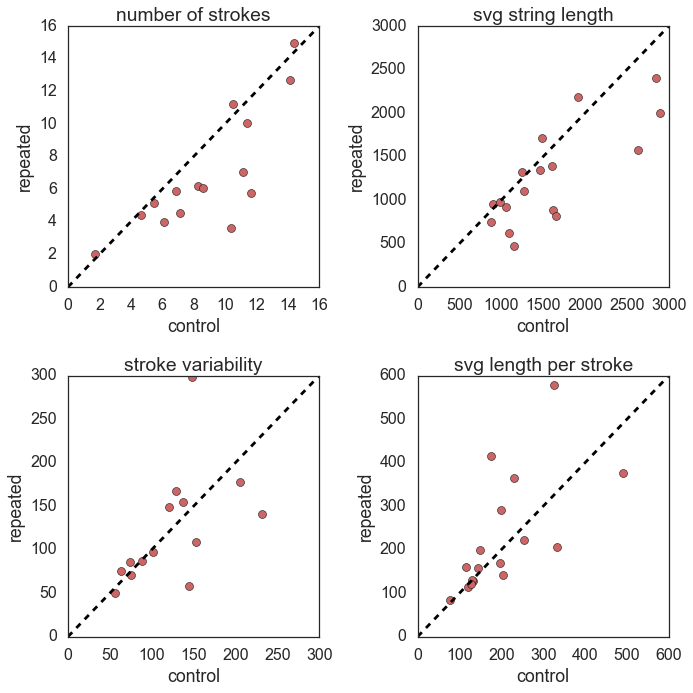

In [17]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

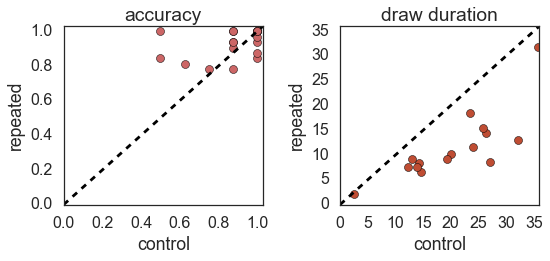

In [18]:
fig = plt.figure(figsize=(8,4))
lb = 0
ub = 1.03
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_accuracy,repeated_accuracy,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('accuracy')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(1,2,2)
lb = 0
ub = 36
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_drawDuration,repeated_drawDuration,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('draw duration')
plt.xlabel('control')
plt.ylabel('repeated')
plt.tight_layout()

In [15]:
# combine information about repeated and distance conditions into trialType
trialType = []
for g in zip(D['repetition'],D['condition']):
    trialType.append(str(g[0]) + '_' + str(g[1]))
D = D.assign(trialType=pd.Series(trialType).values)

In [38]:
# # plot relationship between repetition and numStrokes
# labels = D['trialType']
# colors = sns.color_palette("Paired",n_colors=8)
# color_dict = dict(zip(list(np.unique(labels)),colors))
# df = pd.DataFrame(dict(x=D['repetition'], y=D['numStrokes'], label=labels))
# groups = df.groupby('label')
# fig, ax = plt.subplots(figsize=(8,8))
# ax.margins(0.05)
# for name, group in groups:
#     ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name, alpha=0.5,color=color_dict[name])    
# ax = sns.regplot(group.x, group.y, robust=True, ci=None, marker='o', color=color_dict[name])
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.ylim([0,100])
# plt.xlabel('repetition')
# plt.ylabel('num strokes')
# plt.title('')
# plt.show()

In [58]:
D.columns

Index(['Unnamed: 0', 'gameID', 'trialNum', 'condition', 'target', 'repetition',
       'drawDuration', 'outcome', 'response', 'numStrokes', 'svgStringLength',
       'svgStringLengthPerStroke', 'svgStringStd', 'trialType', 'png'],
      dtype='object')

## Examine images

In [44]:
imgData = D.iloc[0]['png']

In [60]:
def png_from_raw_string(raw_str) :
    """Read in png from raw string"""
    return io.BytesIO(base64.b64decode(raw_str))

def color_outcome(p, outcome):
    """Color green if correct; red if incorrect"""
    if outcome == 1:
        sides = ['bottom','top','right','left']
        for s in sides:
            p.spines[s].set_color((0.4,0.8,0.4))
            p.spines[s].set_linewidth(4)                               
    else:
        sides = ['bottom','top','right','left']
        for s in sides:
            p.spines[s].set_color((0.9,0.2,0.2))
            p.spines[s].set_linewidth(4)    
            
def initialize_subplot(p) :
    sns.set_style('white')
    k = p.get_xaxis().set_ticklabels([])
    k = p.get_yaxis().set_ticklabels([])
    k = p.get_xaxis().set_ticks([])
    k = p.get_yaxis().set_ticks([]) 

In [61]:
sketch_dir = './sketches'

### printing out REPEATED CONDITION sketches 
textsize=12
for gameID in D.gameID.unique():
    print('Printing out sketches from game: ' + gameID)
    game = (D.query('condition=="repeated" and gameID==@gameID')
             .sort_values(by=['target', 'repetition'])
             .reset_index(drop=True))
    fig = plt.figure(figsize=(16,6))
    for i,trial in game.iterrows():
        # Convert raw png string to higher-level io type
        imgData = png_from_raw_string(trial['png'])

        # first plot the target
        im = Image.open(imgData)
        
        # create 4 row x 8 col grid
        p = plt.subplot(4,8,i+1)
        initialize_subplot(p)

        # Add sketch
        plt.imshow(im)
    
        # Color-code to indicate outcome
        color_outcome(p, trial['outcome'])

        # Add column names
        if (i < 8) : 
            plt.title('rep ' + str(trial['repetition']) ,fontsize=textsize)

        # Add row names
        if i % 8 == 0:
            plt.ylabel(trial['target'] ,fontsize=textsize)
#        plt.ylabel(trial['trialNum'] ,fontsize=textsize)

    filepath = os.path.join(sketch_dir,'repeated',gameID + '_' + trial['gameID'] + '_type_' + trial['condition'])
    if not os.path.exists(os.path.join(sketch_dir,'repeated')):
        os.makedirs(os.path.join(sketch_dir,'repeated'))
    plt.savefig(filepath + '.pdf')#, close=True, verbose=False)
    plt.close()


Printing out sketches from game: 4372-c277d1be-60c6-46b4-854b-753ba73a8e32
Printing out sketches from game: 9340-9dcce6e3-2b81-4c14-85b7-732b9cac8447
Printing out sketches from game: 7190-3de99c2b-4e8d-4efb-80b4-369da6636e00
Printing out sketches from game: 4558-f7da5557-4821-4c7c-988a-8027325fa14c
Printing out sketches from game: 2840-855823a3-9d20-40cf-96ed-759c2173c288
Printing out sketches from game: 5327-138a08c2-0e06-4708-9321-a44a1243fad0
Printing out sketches from game: 3556-9eec22ea-269e-4ead-a424-ff10a526f0f6
Printing out sketches from game: 6625-71ce6861-3458-41cd-851d-b6fadba5dc38
Printing out sketches from game: 1590-becfe0c8-317c-4a75-abb3-66a819742985
Printing out sketches from game: 9139-2a820da4-1fd7-4106-84df-04547a6d4d7c
Printing out sketches from game: 1247-854fa242-2e6c-4f2f-b6a0-bf82598208dd
Printing out sketches from game: 1121-d4c90c94-d4e0-4098-a3f7-8edd0b45f84e
Printing out sketches from game: 6868-780d4237-2237-49af-bfb5-e5665f89c089


In [94]:
### printing out CONTROL CONDITION sketches 

#_valid_gameids = valid_gameids[:3]
for g in valid_gameids:
    print('Printing out sketches from game: ' + g)
#     trial_types = np.unique(D2.trialType.values)
#     trial_types = [i for i in list(np.unique(D2.trialType.values)) if i.split('_')[1]=='repeated']
    trial_types = ['control']
    for tt in trial_types:
        _D = D2[(D2.condition=='control') & (D2.gameID==g)]
        _D = _D.sort_values(by=['target','repetition'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(6,16))
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,2,_i)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
#             plt.title(_d['repetition'])
            outcome = _d['outcome']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i-1 < 2) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
#             if (_i < 5) & (tt in 'repeated'):
#                 plt.title(_d['target'] ,fontsize=textsize)
            if (_i-1)%2==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)

            _i  = _i + 1
        filepath = os.path.join(sketch_dir,'control','gameID_' + _d['gameID'] + '_type_' + _d['condition'])
        if not os.path.exists(os.path.join(sketch_dir,'control')):
            os.makedirs(os.path.join(sketch_dir,'control'))
        save(filepath, ext='pdf', close=True, verbose=False)


Printing out sketches from game: 1965-52a1abc6-5806-4638-b72f-056f4a252b07
Printing out sketches from game: 2205-87b10293-f3b9-454c-a2e9-217a12d9685f
Printing out sketches from game: 5380-4e8e8af4-8290-4048-a320-c91c726b4d6d
Printing out sketches from game: 7643-ff6008ea-5d0b-4c32-8bed-28500e8e516c
Printing out sketches from game: 1432-284686d1-bd29-4d6d-b327-eee74e46ab49
Printing out sketches from game: 3077-e15ebc63-b1e2-4391-b52f-eec60d1071d5
Printing out sketches from game: 1295-d0ba610b-dd23-4800-9c6f-1d6f7f0b2f21
Printing out sketches from game: 2904-d5fa6f4a-24e1-4568-b0ed-fb01ad503ed3
Printing out sketches from game: 9471-7c41e215-0c8d-4de0-b6b9-483820e04a67
Printing out sketches from game: 4828-f6ec5851-9e13-4572-b8ed-e62089183a9b
Printing out sketches from game: 3443-fd357b90-2125-45cd-b8de-f9be0a0e720a
Printing out sketches from game: 8075-81e0cc34-dd71-4d6c-8495-d6d764655b7f
Printing out sketches from game: 7734-8c2513e2-42af-4498-9075-e6d5468b7698
Printing out sketches fro

In [98]:
# [i for i in D2.gameID.values if '2904' in i]

Number of miss trials (before last epoch): 9
Number of hit trials (before last epoch): 135


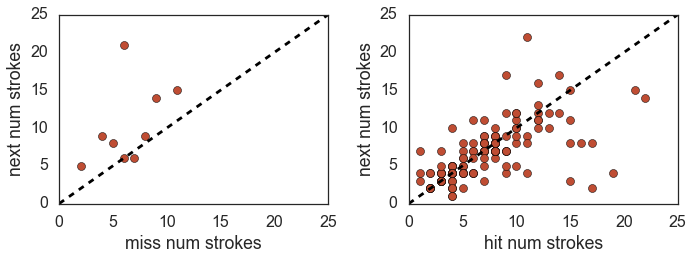

In [418]:
##### this block hasn't been adapted yet
##### Question: If viewer didn't guess the target THIS epoch, did sketcher expend more strokes
##### the next time?

### for g in valid_gameids:
miss_strokes = []
next_strokes = []

hit_strokes = []
hit_next_strokes = []

for g in valid_gameids:
    trial_types = ['repeated_closer','repeated_further','once_closer','once_further']
    for tt in trial_types:
        _D = D[(D.trialType==tt) & (D.gameID==g)]
        _D = _D.sort_values(by=['epoch','target'])
        for i,_d in _D.iterrows():
            if (_d['outcome']==0) & (_d['epoch']<3) & (_d['repeated']=='repeated'): 
                __D = D[(D.trialType==tt) & (D.gameID==g) & (D.epoch==_d['epoch']+1) & (D.target==_d['target'])]
                miss_strokes.append(_d['numStrokes'])
                next_strokes.append(__D['numStrokes'].values[0])  
            elif (_d['outcome']==1) & (_d['epoch']<3) & (_d['repeated']=='repeated'):
                __D = D[(D.trialType==tt) & (D.gameID==g) & (D.epoch==_d['epoch']+1) & (D.target==_d['target'])]
                hit_strokes.append(_d['numStrokes'])
                hit_next_strokes.append(__D['numStrokes'].values[0])
miss_strokes, next_strokes, hit_strokes, hit_next_strokes = list(map(np.array,[miss_strokes, next_strokes, hit_strokes, hit_next_strokes]))
print('Number of miss trials (before last epoch): ' + str(len(miss_strokes)))
print('Number of hit trials (before last epoch): ' + str(len(hit_strokes)))

lb = 0
ub = 25
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(miss_strokes,next_strokes,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.xlabel('miss num strokes')
plt.ylabel('next num strokes')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(hit_strokes,hit_next_strokes,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.xlabel('hit num strokes')
plt.ylabel('next num strokes')
plt.tight_layout()

In [13]:
from matplotlib.path import Path
import matplotlib.patches as patches
from svgpathtools import parse_path, wsvg

# parse weird sketch
g = '2904-d5fa6f4a-24e1-4568-b0ed-fb01ad503ed3'
trialNum = 1
y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': 1}]}).sort('time')
biggie = ''
for rec in y:
    biggie += rec['svgData']
    
parsed = parse_path(biggie)    
_parsed = parsed[:10]
wsvg(_parsed,filename='output.svg')

In [160]:
# for i in np.arange(1,175):
#     _parsed = parsed[:i]
#     wsvg(_parsed,filename='output{}.svg'.format(i))

In [1]:
import time
start = time.time()


In [2]:
end = time.time()

In [3]:
duration = end-start

In [4]:
duration

2.73581600189209